In [ ]:
# manual download from here: https://singlecell.broadinstitute.org/single_cell/study/SCP1303/single-nuclei-profiling-of-human-dilated-and-hypertrophic-cardiomyopathy

from pathlib import Path

import plotnine as pn
import scanpy as sc
import partipy as pt

## downloading the data (or using cached data)
data_dir = Path(".") / "data"

adata = sc.read_h5ad(data_dir / "human_dcm_hcm_scportal_03.17.2022.h5ad")
adata = adata[
    adata.obs["cell_type_leiden0.6"].isin(
        ["Fibroblast_I", "Activated_fibroblast", "Fibroblast_II"]
    ),
    :,
].copy()

cells_cutoff = 100
genes_cutoff = 10

sc.pp.filter_cells(adata, min_genes=cells_cutoff)
sc.pp.filter_genes(adata, min_cells=genes_cutoff)

adata.obs["disease_original"] = adata.obs["disease"].copy()
adata.obs["disease"] = adata.obs["disease_original"].map({"HCM": "CM", "DCM": "CM", "NF": "NF"})

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata, mask_var="highly_variable")
adata.layers["z_scaled"] = sc.pp.scale(adata.X, max_value=10)

print(adata.obs["disease"].value_counts())

pt.compute_shuffled_pca(adata, mask_var="highly_variable", n_shuffle=25)
pt.plot_shuffled_pca(adata)

pt.set_obsm(adata=adata, obsm_key="X_pca", n_dimensions=16)

pt.compute_selection_metrics(adata=adata, n_archetypes_list=range(2, 8))
pt.plot_var_explained(adata)
pt.plot_IC(adata)

pt.compute_bootstrap_variance(
    adata=adata, n_bootstrap=50, n_archetypes_list=range(2, 8)
)
pt.plot_bootstrap_variance(adata)



/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.


disease
CM    109000
NF     38219
Name: count, dtype: int64

In [1]:
pt.plot_archetypes_2D(adata=adata, show_contours=True, result_filters={"n_archetypes": 4}, alpha=0.05)

NameError: name 'pt' is not defined

/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[str, any]` - serialized value may not be as expected [field_name='optim_kwargs', input_value=(), input_type=tuple])


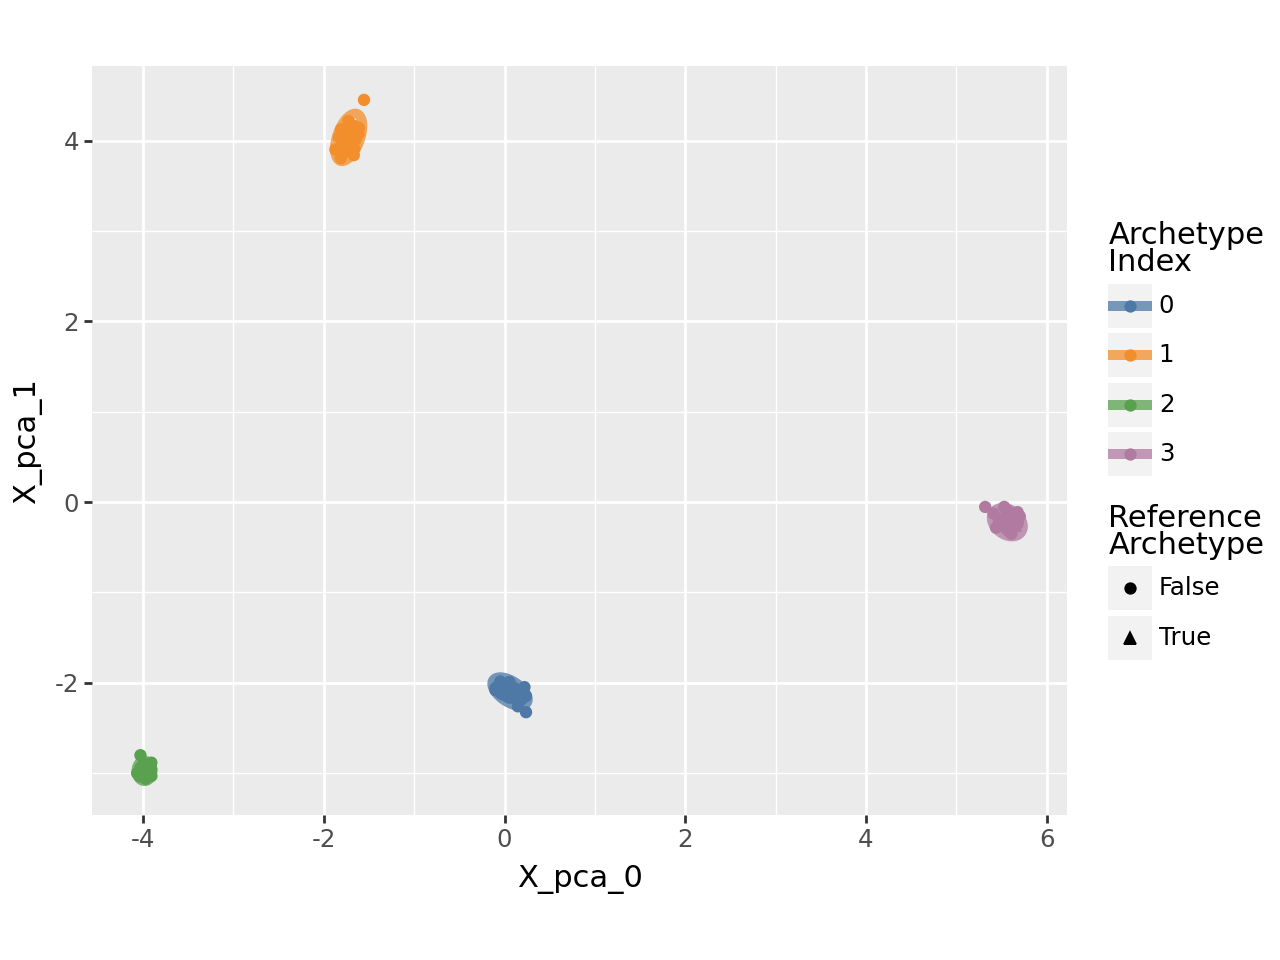

In [11]:
pt.plot_bootstrap_2D(adata, result_filters={"n_archetypes": 4})

In [12]:
significance = pt.t_ratio_significance(adata, result_filters={"n_archetypes": 4})

Randomizing: 100%|██████████| 100/100 [00:00<00:00, 113666.78it/s]
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.ve

KeyboardInterrupt: 

/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[str, any]` - serialized value may not be as expected [field_name='optim_kwargs', input_value=(), input_type=tuple])


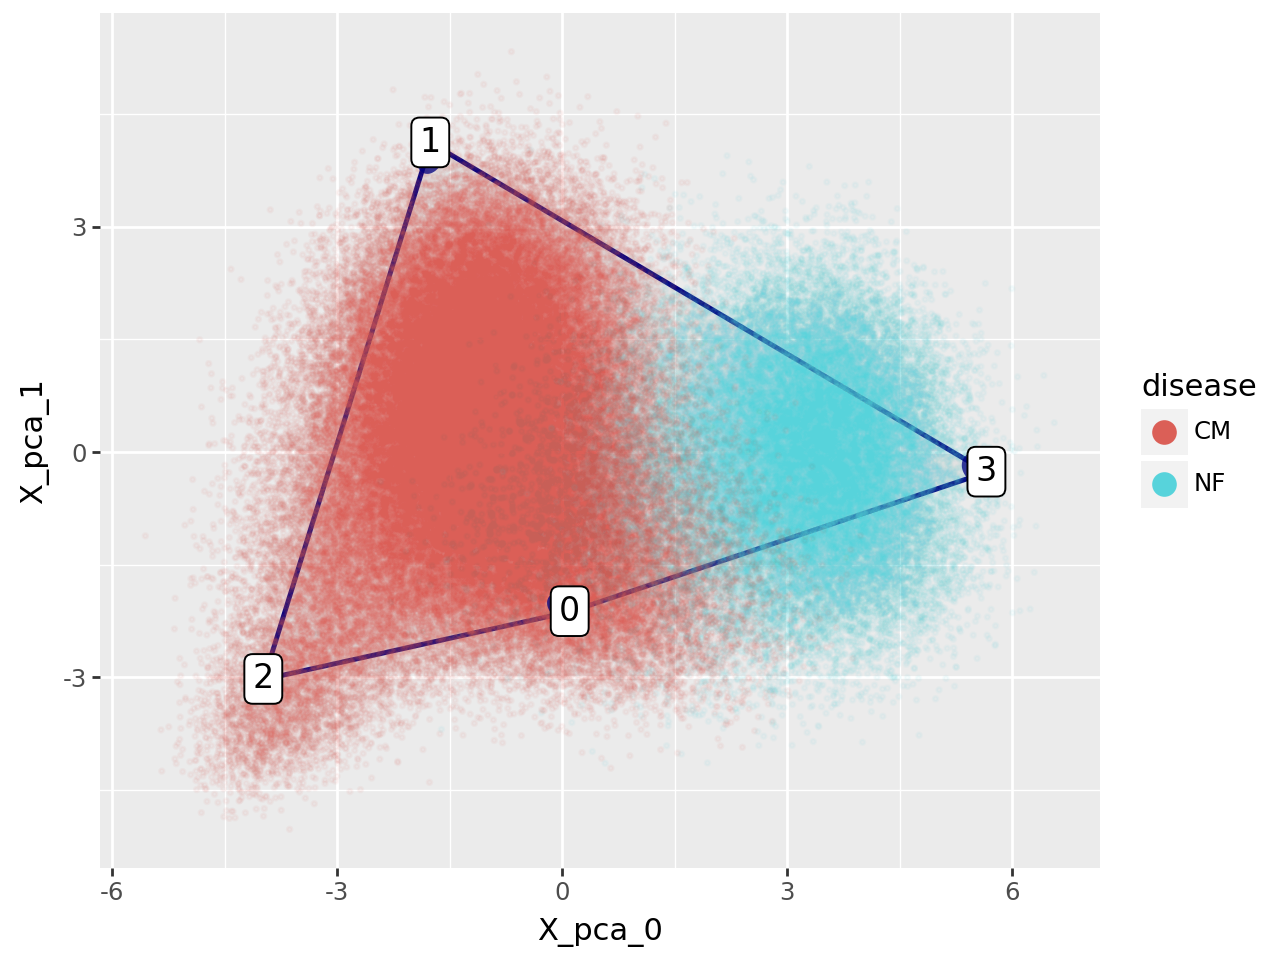

In [18]:
pt.plot_archetypes_2D(adata=adata, show_contours=True, color="disease", alpha=0.05, size=0.5, result_filters={"n_archetypes": 4}) + pn.guides(color=pn.guide_legend(override_aes={"alpha": 1.0, "size": 4.0}))

In [14]:
pt.compute_archetype_weights(adata=adata, mode="automatic", result_filters={"n_archetypes": 4})

Applied length scale is 2.59.


In [15]:
status_enrichment = pt.compute_meta_enrichment(adata=adata, meta_col="disease", result_filters={"n_archetypes": 4})
status_enrichment

,CM,NF
0,0.664828,0.335172
1,0.817677,0.182323
2,0.886511,0.113489
3,0.056675,0.943325


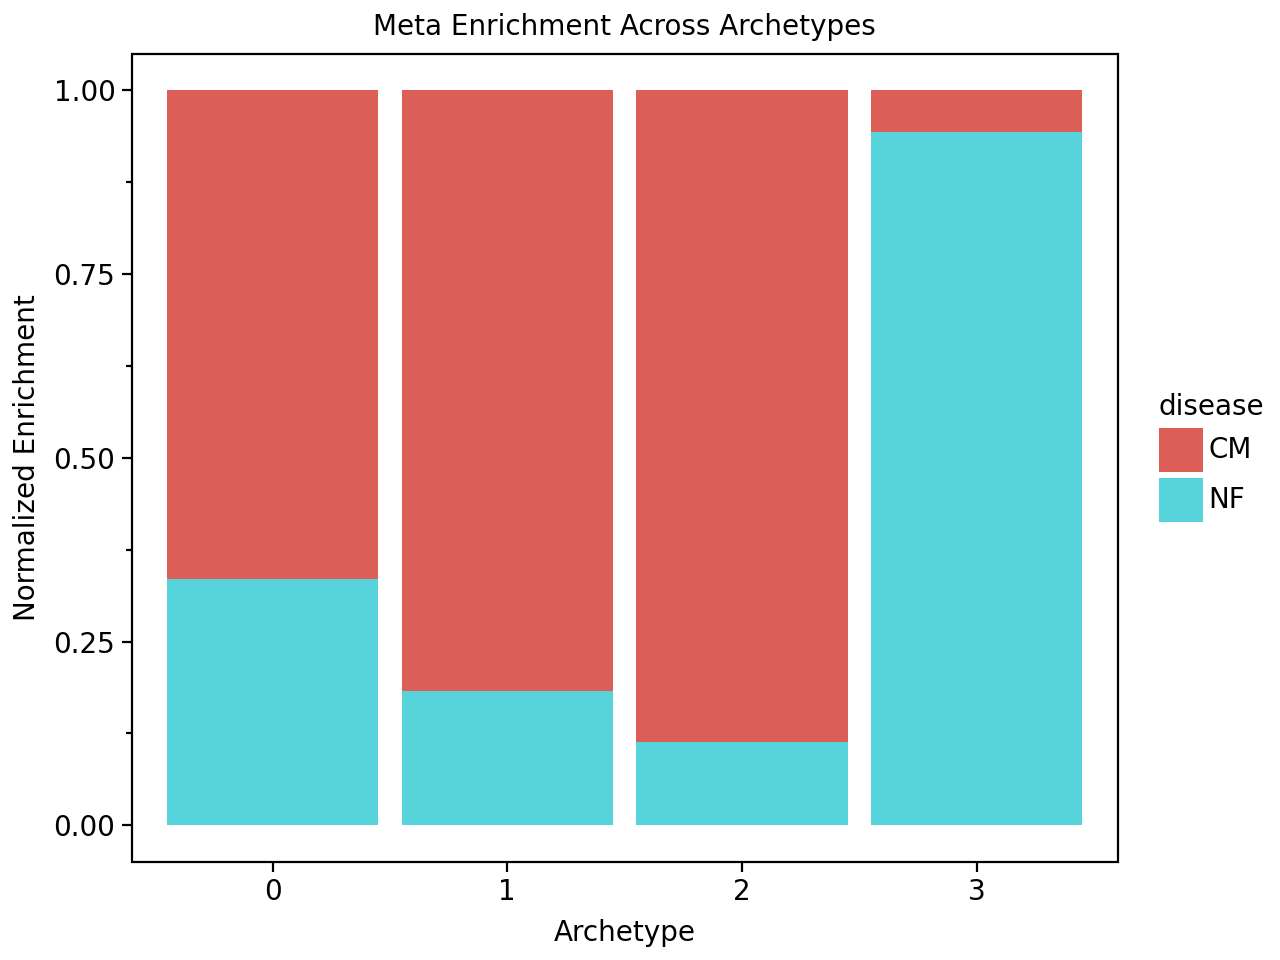

In [16]:
pt.barplot_meta_enrichment(status_enrichment, meta="disease")